In [22]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

device = 'cpu'

We want to see how the morphology of the network affects the speed of learning. 

In [49]:
from utils import select_model

list_of_layer_depth = [2, 4, 5, 6, 7, 10]  # number of layers
list_of_models = ['unconditional-dendritic-' + str(l) + '-layers' for l in list_of_layer_depth]


def load_model_weights_from_chkpt(model_name, model_num, epoch_number, checkpoint_path='saved_weights'):
    model, num_steps, ambient_dims = select_model(model_name, model_num)

    checkpoint_path = os.path.join(base_dir, 'core', checkpoint_path, f'{model_name}_{str(model_num)}')
    epoch_file = 'epoch='+str(epoch_number)
    file = torch.load(os.path.join(checkpoint_path, epoch_file, 'checkpoint.pt'))
    state_dict = file['model_state_dict']
    model.load_state_dict(state_dict)
    model.eval()

    return model, num_steps, ambient_dims

model, num_steps, ambient_dims = load_model_weights_from_chkpt(list_of_models[0], 1, 0)
print(model)

model loaded!
VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
  )
)


In [45]:
# now load all models at the same epoch
epoch_num = 1490000
model_num = 4

models = []
for i in range(len(list_of_models)):
    model = load_model_weights_from_chkpt(list_of_models[i], model_num, epoch_num)[0]
    models.append(model)



model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!


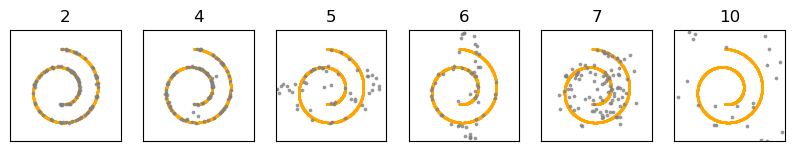

In [50]:
# now generate samples from all models for a given epoch
temp = 100
lim = 1.5
lims = [-lim, lim]
sample_size = int(1e2)
from prior_utils import p_sample_loop
from dataset_utils import generate_2d_swiss_roll
gt_manifold = generate_2d_swiss_roll(int(1e3), True, return_as_tensor=True)[1]

fig, ax = plt.subplots(1, len(models), figsize=(10,2))
for i, model in enumerate(models):
    x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
    
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*x_rev[-1].T, s=3, alpha=0.7, color='grey')
    ax[i].set(title=f'{list_of_layer_depth[i]}')
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xlim=lims, ylim=lims)
        remove_all_ticks_and_labels(a)
    